# Supervised Capstone Project

The goal of this capstone project was to develop predictions for car classifieds, the two most important predictions being the price at which a particular car will be posted at, and how long said posting will last. Then I worked to visualize the decision process of the tree to better understand how it was coming to the conclusion it was, as to help car owners and buyers understand what sort of car features causes a particular listing to be priced as it is. 

In [297]:
import pandas as pd 
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import scipy.linalg as la
from sklearn import preprocessing


In [298]:
df = pd.read_csv(r"D:\Data For Python\used-cars-database\autos.csv", encoding='latin1')

In [299]:
df.isnull().sum()

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

In [300]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [301]:
df.shape

(371528, 20)

In [302]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


In [303]:
df.shape

(371528, 20)

A couple of suspicious instances stand out here. Every meta value for nrOfPictures is 0. Let's check on that. 

In [304]:
df["nrOfPictures"].value_counts()

0    371528
Name: nrOfPictures, dtype: int64

As suspected, it's all zero. We can safely remove it. This does bring to question the other categorical variables, however. 

In [305]:
df["seller"].value_counts()

privat        371525
gewerblich         3
Name: seller, dtype: int64

I doubt those three data points add a ton. As a sidenote, the two values indicate whether the seller was private or commercial. I suppose most car dealerships didn't really want to turn to classifieds to sell cars. 

In [306]:
df["offerType"].value_counts()

Angebot    371516
Gesuch         12
Name: offerType, dtype: int64

I might not be translating this correctly, but I think Angebot are offers, and Gesuchs are requests, once again, the offertype is not really spetacular here. Let's get rid of it. 

In [307]:
df["name"].value_counts()

Ford_Fiesta                                                       657
BMW_318i                                                          627
Opel_Corsa                                                        622
Volkswagen_Golf_1.4                                               603
BMW_316i                                                          523
BMW_320i                                                          492
Volkswagen_Polo                                                   475
Renault_Twingo                                                    447
Volkswagen_Golf                                                   428
Volkswagen_Golf_1.6                                               413
Volkswagen_Polo_1.2                                               412
BMW_116i                                                          394
Opel_Corsa_1.2_16V                                                373
Opel_Corsa_B                                                      369
Opel_Astra          

Car models are somewhat, genericized versions of the car name, from our perspective. They might be more useful. 

In [308]:
df['model'].value_counts()

golf                  30070
andere                26400
3er                   20567
polo                  13092
corsa                 12573
astra                 10830
passat                10306
a4                    10257
c_klasse               8775
5er                    8546
e_klasse               7561
a3                     6604
a6                     6023
focus                  5950
fiesta                 5775
transporter            5528
twingo                 4953
2_reihe                4816
fortwo                 4338
a_klasse               4316
vectra                 4255
1er                    3837
mondeo                 3626
clio                   3553
touran                 3540
3_reihe                3503
punto                  3349
zafira                 3049
megane                 2927
ka                     2702
                      ...  
mii                      81
crossfire                66
range_rover_evoque       65
gl                       64
nubira              

Ah. Well, it has enough of a dominant category to still be useful. We'll leave it in. 

In [309]:
df['notRepairedDamage'].value_counts()

nein    263182
ja       36286
Name: notRepairedDamage, dtype: int64

While it might seem like a small category, I imagine having damage outstanding on the car would very adversely affect it's sale value, so it'll be left in. 

We have a few names that look like they occur often enough to warrant inclusion, but recalling the size of our dataset, we know that they really aren't as common as they may seem. We can probably drop it, just to save the headache. 

I'm guessing AB test represents a treatment done to the actual people scrapping the data, but I don't know what that treatment is. We can use it in prediction, but not in any informative way. I kinda assumed that there would be too many names in the names column to be useful, but I'd like to confirm it.  

Postal code is going to have possibly more unique values than the car names, and even less information on the value of the sale. We can get rid of it too. 

I suspect gearbox, vehicle type, and fuel type will be just general enough to be usable, but varied enough to contain information. I'll check though. 

In [310]:
df["gearbox"].value_counts()

manuell      274214
automatik     77105
Name: gearbox, dtype: int64

In [311]:
df["vehicleType"].value_counts()

limousine     95894
kleinwagen    80023
kombi         67564
bus           30201
cabrio        22898
coupe         19015
suv           14707
andere         3357
Name: vehicleType, dtype: int64

In [312]:
df["fuelType"].value_counts()

benzin     223857
diesel     107746
lpg          5378
cng           571
hybrid        278
andere        208
elektro       104
Name: fuelType, dtype: int64

Beautiful, these features will be usefull. The rest however, can be dropped with little issue.

The dominant class of the "notRepairedDamage" damage category is "nien" so we'll fill in it's null values using that. 

In [314]:
df["notRepairedDamage"].fillna("nein",inplace = True)

We don't have too substantial of a missing dataset here, and the rest of this can be relatively difficult to infer from the remaining data. We'll see if we can drop it. 


In [315]:
df = df.dropna()
df.shape

(299864, 20)

Still plenty of data to work with. 

Then there are the dates in the dataset. I'm tempted to just remove them, but I think we can find our own insights into how cars are sold in classifieds using them. I want to know how long a classfied is up before it's taken down, presumably in most cases because the person found a buyer or gave up. The date-crawled just indicates when the entry was collected by the scraper. It doesn't have any useful info for us. 

In [316]:
df['lastSeen'] = pd.to_datetime(df['lastSeen'])
df['dateCreated'] = pd.to_datetime(df['dateCreated'])
df['uptime'] = df['lastSeen']-df['dateCreated']
df['uptime'].head()

2   22 days 12:47:46
3    0 days 17:40:17
4    6 days 10:17:21
5    2 days 19:17:07
6    4 days 18:18:39
Name: uptime, dtype: timedelta64[ns]

Now all that is left is to try to drop the data that we don't want. 

In [317]:
df = df.drop(['nrOfPictures', 'seller', 'postalCode', 'offerType', 'name', 'lastSeen', 'dateCreated', 'dateCrawled'], axis = 1)

In [318]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,uptime
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,nein,22 days 12:47:46
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,0 days 17:40:17
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,6 days 10:17:21
5,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,2 days 19:17:07
6,2200,test,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,nein,4 days 18:18:39


Uptime looks good but we need to convert it to a more usable data type. 

In [319]:
df['total_hours_uptime'] = df['uptime'].dt.total_seconds() / (60 * 60)
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,uptime,total_hours_uptime
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,nein,22 days 12:47:46,540.796111
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,0 days 17:40:17,17.671389
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,6 days 10:17:21,154.289167
5,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,2 days 19:17:07,67.285278
6,2200,test,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,nein,4 days 18:18:39,114.310833


Now we can explore the data. 

Well, one take away from this chart is there there are some extreme outliers in how long a classified will stay up. We might have to approach this differently. 

In [320]:
df.groupby(['gearbox']).mean()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,total_hours_uptime
gearbox,,,,,,
automatik,15997.060571,2004.341506,175.228243,122223.444997,6.272234,243.037340
manuell,6342.874638,2002.520627,108.333261,126217.044361,6.022420,224.950743


In [321]:
df.isnull().sum()

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
uptime                 0
total_hours_uptime     0
dtype: int64

In [287]:
df["yearOfRegistration"].describe()

count    299864.000000
mean       2002.934464
std           6.579942
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2018.000000
Name: yearOfRegistration, dtype: float64

1910 is a little old, but it's possible there are cars listed at that price, they're probably fairly expensive, however, being antiques. 

Text(0.5,1,'Price frequency in german auto classifieds')

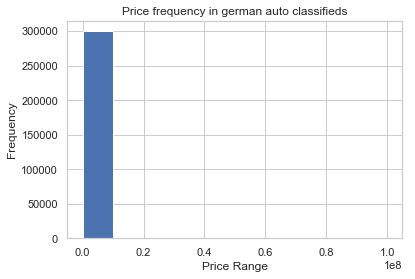

In [324]:
df['price'].hist()
plt.xlabel("Price Range")
plt.ylabel("Frequency")
plt.title('Price frequency in german auto classifieds')

In [326]:
df['price'].describe()

count    2.998640e+05
mean     8.537011e+03
std      4.196486e+05
min      0.000000e+00
25%      1.400000e+03
50%      3.500000e+03
75%      7.999000e+03
max      1.000000e+08
Name: price, dtype: float64

There's obviously some heavy skew, skew that is relevant to our output variable, but skew nonethe less, I'll check the sizes of different parts of the data set below and above some reasonable paramateres, see if there 

In [289]:
df[df.price > 100000].shape

(237, 14)

In [290]:
df[df.price < 100].shape

(5987, 14)

In [291]:
df[df.price < 1].shape

(5044, 14)

So, there's a substantial number of cars with 0 value, I guess some people simply want to get rid of old cars. It's something that is good to know, but difficult for our model to train and test on. We'll take note of it and remove them from the set. The cars that go over 100000 euros might be worth taking a look at. Just to get the idea of what sort of cars demand that sort of pricing. 

I know some cars are expensive, but that seems unreasonable, let's look into them. 

In [325]:
df.sort_values(by='price',  ascending=False)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,uptime,total_hours_uptime
77520,99999999,control,limousine,1999,automatik,224,s_klasse,150000,9,benzin,mercedes_benz,nein,15 days 05:15:30,365.258333
139052,99999999,control,coupe,2009,automatik,224,andere,150000,11,diesel,mercedes_benz,ja,0 days 22:40:52,22.681111
280059,99999999,control,andere,1974,manuell,0,golf,150000,6,benzin,volkswagen,nein,19 days 16:15:27,472.257500
127820,99999999,test,kombi,1999,manuell,165,a6,5000,12,benzin,audi,nein,0 days 17:49:54,17.831667
251980,99000000,test,limousine,2009,automatik,190,a6,150000,11,diesel,audi,nein,4 days 04:45:53,100.764722
183361,32545461,control,limousine,2004,automatik,175,5er,5000,10,lpg,bmw,nein,2 days 00:18:31,48.308611
87799,27322222,control,limousine,2014,manuell,163,c4,40000,2,diesel,citroen,nein,0 days 20:39:05,20.651389
279937,14000500,control,coupe,2008,automatik,231,clk,125000,5,benzin,mercedes_benz,nein,0 days 11:56:00,11.933333
241847,12345678,control,limousine,2001,manuell,101,vectra,150000,3,benzin,opel,nein,0 days 18:56:54,18.948333
287835,12345678,test,kombi,2001,manuell,101,focus,150000,0,benzin,ford,nein,6 days 21:18:10,165.302778


Looking these cars up, it's fairy unlikely that their owners actually evaluated them this high, it's more likely that these were either a result of input error or some glitch in the system. While eye opening to the administrators of the site, there isn't much analytical value in leaving them in.

In [327]:
df = df.drop(df[df.price > 100000].index)
df = df.drop(df[df.price < 100].index)

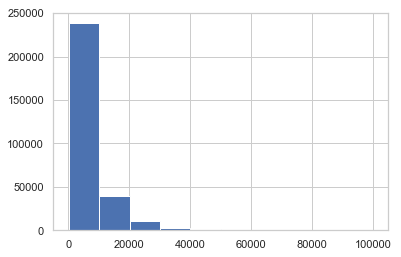

In [328]:
#checking to see if the code above had the intended effect 
df['price'].hist()

There's still a glut of cars offered at 0$. While it does make the model less accurate, its also a relevant predictor, some cars probably do have 0 to negative value in their owners and sellers eyes, and it is a legitimate part of the outcome variable. That said, a lot of this data is heavily skewed in a way that seems unreasonable, given the info we pulled up above, we can standardize it a bit more. 

In [329]:
df['price'].describe()

count    293640.000000
mean       6295.082823
std        7735.521247
min         100.000000
25%        1499.000000
50%        3542.000000
75%        8190.000000
max      100000.000000
Name: price, dtype: float64

In [330]:
df['price'].mean()

6295.082822503746

In [371]:
df[df.price > (df['price'].median() + 2*df['price'].std())].shape

(17736, 14)

I'm comfortable loosing 18k data points, given the size the data set and the extent of the skew.

In [344]:
df[df.price < (df['price'].median() - 2*df['price'].std())].shape

(0, 14)

And we don't even have to trim anything off the bottom to remain consistent. 

In [336]:
list(dfc)

['price',
 'abtest',
 'vehicleType',
 'yearOfRegistration',
 'gearbox',
 'powerPS',
 'model',
 'kilometer',
 'monthOfRegistration',
 'fuelType',
 'brand',
 'notRepairedDamage',
 'uptime',
 'total_hours_uptime']

In [337]:
dfc.isnull().sum()

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
uptime                 0
total_hours_uptime     0
dtype: int64

In [375]:
print(dfc.shape)

print(df.shape)

(280097, 14)
(293640, 14)


We have a decent frame in which to drop outliers out of our dataset. But before I declare that dataframe, I found an alternative to get dummies, which might work better for our data. Let's work on that. 

In [376]:
from sklearn.preprocessing import LabelEncoder

df["vehicleType"] =LabelEncoder().fit_transform(df["vehicleType"])
df["fuelType"] =LabelEncoder().fit_transform(df["fuelType"])
df["gearbox"] =LabelEncoder().fit_transform(df["gearbox"])
df["notRepairedDamage"] =LabelEncoder().fit_transform(df["notRepairedDamage"])
df["brand"] =LabelEncoder().fit_transform(df["brand"])
df["model"] =LabelEncoder().fit_transform(df["model"])
df["abtest"] =LabelEncoder().fit_transform(df["abtest"])
df.head()


,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,uptime,total_hours_uptime
2,9800,1,7,2004,0,163,119,125000,8,3,14,1,22 days 12:47:46,540.796111
3,1500,1,4,2001,1,75,118,150000,6,1,37,1,0 days 17:40:17,17.671389
4,3600,1,4,2008,1,69,103,90000,7,3,31,1,6 days 10:17:21,154.289167
5,650,1,6,1995,1,102,11,150000,10,1,2,0,2 days 19:17:07,67.285278
6,2200,1,2,2004,1,109,8,150000,8,1,25,1,4 days 18:18:39,114.310833


In [377]:
dfc = df[df['price'] < (df['price'].mean() + 2*df['price'].std())]

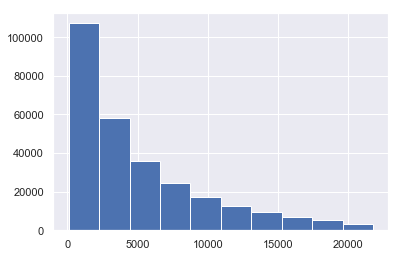

In [378]:
dfc.price.hist()

In [379]:

dft = dfc.drop(['price', 'abtest', 'total_hours_uptime', 'uptime'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(dft, dfc.price, test_size=.20)
y = y_train
X = x_train
print(y.shape, X.shape, y_train.shape, y_test.shape)

(224077,) (224077, 10) (224077,) (56020,)


In [380]:
rfr = RandomForestRegressor(max_depth=20)
rfr.fit(X, y)
rfr.score(x_test, y_test)

0.8874270217726145

Hey not bad, we can predict the price with an 89% R2 score. Now lets see if we can predict the uptime for any classified posted with a given price. First let's give it a bit of normalization. I experimented with removing some of the features that were given to the model. Surprisingly, removal of the mileage on a car, and the unrepaired damage category had relatively little impact. However, things like horsepower, year and month of registration, brand had a ton of impact, and the 

Bellow is the code to produce the visualizations for the random trees, they are computationally intensive, and only provide output in the form of an SVG provided on the chart. For this reason they are commented out of the code for efficiencies sake, but any reviewer may look or run the code if they are interested. 

In [381]:

# from sklearn.datasets import *
# from sklearn import tree
# from dtreeviz.trees import *
# Regressor = tree.DecisionTreeRegressor(max_depth = 3)
# Regressor.fit(X, y)

# viz = dtreeviz(Regressor, 
#                x_test, 
#                y_test,
#                target_name='price',
#               feature_names=list(X)
#                   )  
              
# viz.view() 

Now onto uptime of a classified. 

In [351]:
df['total_hours_uptime'].describe()

count    293640.000000
mean        229.931100
std         207.389772
min           0.603889
25%          63.766389
50%         161.796667
75%         345.786111
max        9219.750278
Name: total_hours_uptime, dtype: float64

Evidently one classified stayed up over a year. We'll trim off some of the outliers here. Lets limit it to those that lasted a day before being taken down, and those that were taken down within a month. 

In [352]:
df[df.total_hours_uptime > 1000].shape

(207, 14)

In [353]:
df[df.total_hours_uptime < 5].shape

(302, 14)

In [354]:
dftime = df[(df.total_hours_uptime > 5) & (df.total_hours_uptime < 1000) ]

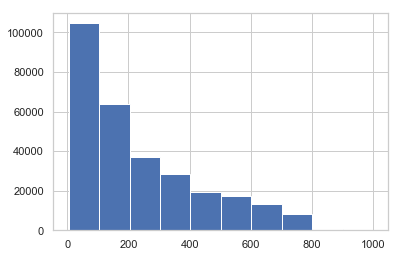

In [355]:
dftime.total_hours_uptime.hist()

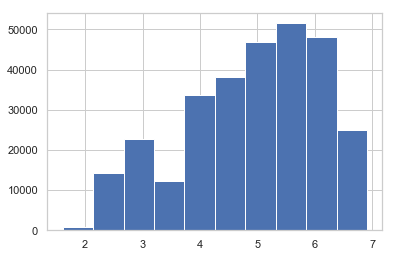

In [356]:

np.log(dftime.total_hours_uptime).hist()

In [357]:
dftime['total_hours_uptime'] = np.log(dftime['total_hours_uptime'])

C:\Users\Ebel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


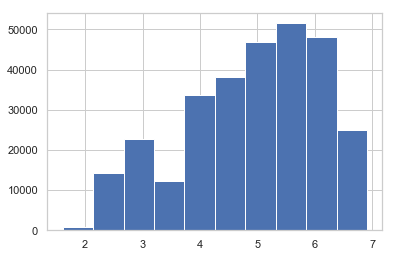

In [358]:
dftime.total_hours_uptime.hist()

In [359]:



dft = dftime.drop(['uptime', 'total_hours_uptime'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(dft, dftime['total_hours_uptime'], test_size=.20)
y = y_train
X = x_train
print(y.shape, X.shape, x_test.shape, y_test.shape)

(234504,) (234504, 12) (58627, 12) (58627,)


In [360]:
rfr = RandomForestRegressor(max_depth=10)
rfr.fit(X, y)
rfr.score(x_test, y_test)

0.0847106165396605

So even after standardizing the values a fair amount, we find ourselves without a reasonable ability to predict the uptime of a particular classified ad. I'll try boosting instead of bagging and see if that makes a difference, and then we might have to rethink our approach. If we can't accurately predict the time in a regression then we might switch to a simpler logistic classifier, that might be able to provide some utility in giving a warning to all listings that appear to be risking an inordinately long time. 

First we'll try boosting. 

In [49]:
gbr = GradientBoostingRegressor()
gbr.fit(X, y)
gbr.score(x_test, y_test)

0.0651408483497371

Did not work well. Time to think about how to make a classifier for this outcome, first defining a long wait will reqiure us to look at the data. 

In [364]:
#We'll undo the log with a natural exponent. 
print(np.exp(dftime['total_hours_uptime'].median()))

162.2630555555555


So... 162 hours is the median, that's a little under a week, or 168 hours. That seems like a reasonable amount of time to sell in a car, but it does represent the best place to divide our data in two groups, and determining what causes above average sell times.  So let's go ahead and set it to 3 weeks or 504 hours. 

In [365]:
dftime['LongWait'] = np.where(dftime['total_hours_uptime'] > np.log(168), 1, 0)
dftime['LongWait'].mean()

C:\Users\Ebel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.4927455642698998

In [367]:
#Unlike before, price would probably be known to the program as it had been put in by the seller. We'll be able to use it here.
dft = dftime.drop(['uptime', 'total_hours_uptime', 'LongWait'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(dft, dftime['LongWait'], test_size=.20)
y = y_train
X = x_train
print(y.shape, X.shape, x_test.shape, y_test.shape)

(234504,) (234504, 12) (58627, 12) (58627,)


In [368]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X, y)
rfc.score(x_test, y_test)

0.584099476350487

In [57]:
# classifier = tree.DecisionTreeClassifier(max_depth = 4 )
# classifier.fit(X, y)

# viz = dtreeviz(classifier, 
#                X, 
#                y,
#                target_name='LongWait',
#               feature_names=list(X), 
#                class_names=[1, 0]  # need class_names for classifier
#               )  
              
# viz.view() 

For reference I ran a couple of different iterations with different features removed. The most had a negligble but cumulative difference that influenced it's accuracy. The features that did have an impact were; Price and kilometer. The other featuers had negligible impact, but still had a cumulative effect when dropped together. Overall, this model preforms slightly better than the dominant class. Not really useful from a practical standpoint, but it can help demonstrate what goes into how long a car takes to be bought. That said, it might be time to move past the blackbox methods and see what I might accomplish with some regular visulizations, T-Tests, and possibly some regressions. 

Text(0.5,1,'Uptime of different types of gearboxes in classified advertisements of car sale for normalized data')

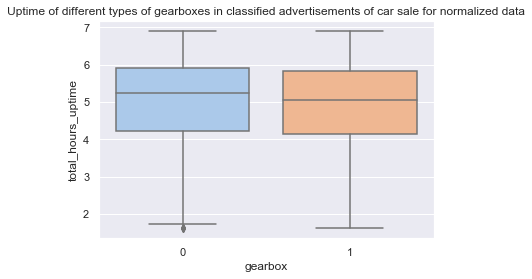

In [369]:
sns.set(style="darkgrid")

ax = sns.boxplot(x='gearbox',y='total_hours_uptime', data=dftime ,palette='pastel')  

plt.title('Uptime of different types of gearboxes in classified advertisements of car sale for normalized data')


In [395]:
#This is mostly to doublecheck the labels are right, manuel was the the dominant class, so whether 0 or 1s are dominant is a good way to double check which is which. 
df.gearbox.value_counts()

1    226618
0     67022
Name: gearbox, dtype: int64

This makes it look pretty insignificant, but we'll run a T-Test to be sure. 

In [383]:
man = dftime[dftime['gearbox'] > .5]
auto = dftime[dftime['gearbox'] < .5]

In [387]:
scipy.stats.ttest_ind(man.total_hours_uptime, auto.total_hours_uptime, equal_var=True)

Ttest_indResult(statistic=-20.02316880070217, pvalue=3.970604778533975e-89)

So gearbox, which was used by the model produces some very significant differences. Good to have the methodology validated a bit. Let's try using something not used by the model. 

In [390]:
dftime["fuelType"].value_counts()

1    191520
3     96213
6      4541
2       489
5       218
0        88
4        62
Name: fuelType, dtype: int64

In [392]:
gasoline = dftime[dftime['fuelType'] > .5]
diesel = dftime[dftime['fuelType'] < .5]

In [393]:
scipy.stats.ttest_ind(gasoline.total_hours_uptime, diesel.total_hours_uptime, equal_var=True)

Ttest_indResult(statistic=-2.089452690905778, pvalue=0.03666785229355743)

Still significant, but not as significant as other features with more importance in the random forest. This can give some insight and back up our finding that some features are less important than others to car value. 

I kinda need to undo a lot of what I did to the data set, especially the label encoding, if I'm going to try the models below. For that reason I'm reloading the data frame and putting it through it's cleaning paces again. A lot of the steps below are repeats of the steps above, so I'm not really denoting them. 

In [413]:
df = pd.read_csv(r"D:\Data For Python\used-cars-database\autos.csv", encoding='latin1')

In [414]:
df["notRepairedDamage"].fillna("nein",inplace = True)

In [415]:
df = df.dropna()
df.shape

(299864, 20)

In [416]:
df["notRepairedDamage"].fillna("nein",inplace = True)

In [417]:
df['lastSeen'] = pd.to_datetime(df['lastSeen'])
df['dateCreated'] = pd.to_datetime(df['dateCreated'])
df['uptime'] = df['lastSeen']-df['dateCreated']
df['uptime'].head()

2   22 days 12:47:46
3    0 days 17:40:17
4    6 days 10:17:21
5    2 days 19:17:07
6    4 days 18:18:39
Name: uptime, dtype: timedelta64[ns]

In [418]:
df['total_hours_uptime'] = df['uptime'].dt.total_seconds() / (60 * 60)
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,...,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,uptime,total_hours_uptime
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,...,8,diesel,jeep,nein,2016-03-14,0,90480,2016-04-05 12:47:46,22 days 12:47:46,540.796111
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,...,6,benzin,volkswagen,nein,2016-03-17,0,91074,2016-03-17 17:40:17,0 days 17:40:17,17.671389
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,...,7,diesel,skoda,nein,2016-03-31,0,60437,2016-04-06 10:17:21,6 days 10:17:21,154.289167
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,privat,Angebot,650,test,limousine,1995,manuell,102,...,10,benzin,bmw,ja,2016-04-04,0,33775,2016-04-06 19:17:07,2 days 19:17:07,67.285278
6,2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,privat,Angebot,2200,test,cabrio,2004,manuell,109,...,8,benzin,peugeot,nein,2016-04-01,0,67112,2016-04-05 18:18:39,4 days 18:18:39,114.310833


In [420]:
df = df.drop(df[df.price > 150000].index)
df = df.drop(df[df.price < 100].index)
dfnt = df.drop(['total_hours_uptime', 'uptime'], axis =1 )

In [421]:
df = df.drop(['nrOfPictures', 'seller', 'postalCode', 'offerType', 'name', 'lastSeen', 'dateCreated', 'dateCrawled'], axis = 1)

This is the big difference between the two preps, I'll be using dummies instead of scalar values this time. 

In [90]:
dfm = pd.get_dummies(df)
dfm.shape

(293758, 319)

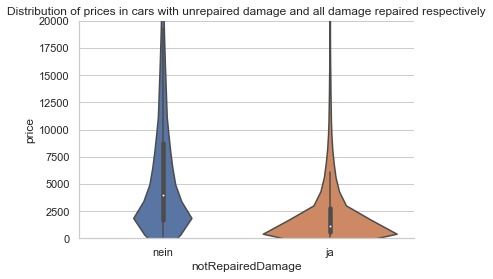

In [422]:
sns.set_style("whitegrid")
ax = sns.violinplot(x="notRepairedDamage", y="price", data=df)
ax.set(ylim=(0, 20000))
ax.set_title('Distribution of prices in cars with unrepaired damage and all damage repaired respectively')
sns.despine()


In [423]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,uptime,total_hours_uptime
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,nein,22 days 12:47:46,540.796111
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,0 days 17:40:17,17.671389
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,6 days 10:17:21,154.289167
5,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,2 days 19:17:07,67.285278
6,2200,test,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,nein,4 days 18:18:39,114.310833


In [424]:
dftime = dfm[(dfm.total_hours_uptime > 5) & (dfm.total_hours_uptime < 1000) ]

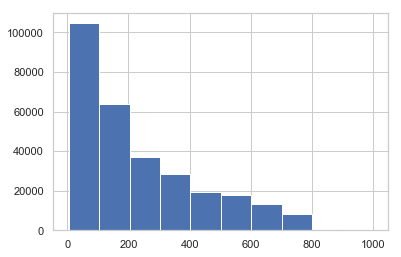

In [425]:
dftime.total_hours_uptime.hist()

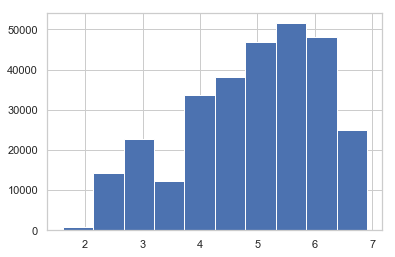

In [426]:

np.log(dftime.total_hours_uptime).hist()

In [427]:
dftime['total_hours_uptime'] = np.log(dftime['total_hours_uptime'])

C:\Users\Ebel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


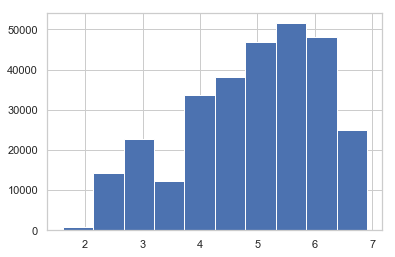

In [428]:
dftime.total_hours_uptime.hist()

In [429]:
list(dftime)

['price',
 'yearOfRegistration',
 'powerPS',
 'kilometer',
 'monthOfRegistration',
 'High_sale',
 'uptime',
 'total_hours_uptime',
 'abtest_control',
 'abtest_test',
 'vehicleType_andere',
 'vehicleType_bus',
 'vehicleType_cabrio',
 'vehicleType_coupe',
 'vehicleType_kleinwagen',
 'vehicleType_kombi',
 'vehicleType_limousine',
 'vehicleType_suv',
 'gearbox_automatik',
 'gearbox_manuell',
 'model_100',
 'model_145',
 'model_147',
 'model_156',
 'model_159',
 'model_1_reihe',
 'model_1er',
 'model_200',
 'model_2_reihe',
 'model_300c',
 'model_3_reihe',
 'model_3er',
 'model_4_reihe',
 'model_500',
 'model_5_reihe',
 'model_5er',
 'model_601',
 'model_6_reihe',
 'model_6er',
 'model_7er',
 'model_80',
 'model_850',
 'model_90',
 'model_900',
 'model_9000',
 'model_911',
 'model_a1',
 'model_a2',
 'model_a3',
 'model_a4',
 'model_a5',
 'model_a6',
 'model_a8',
 'model_a_klasse',
 'model_accord',
 'model_agila',
 'model_alhambra',
 'model_almera',
 'model_altea',
 'model_amarok',
 'model_a

In [434]:
dftime['LongWait'] = np.where(dftime['total_hours_uptime'] > np.log(168), 1, 0)
dftime['LongWait'].mean()

C:\Users\Ebel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.4927859941551378

In [435]:



dft = dftime.drop(['uptime', 'total_hours_uptime', 'LongWait'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(dft, dftime['LongWait'], test_size=.20)
y = y_train
X = x_train
print(y.shape, X.shape, x_test.shape, y_test.shape)

(234599,) (234599, 317) (58650, 317) (58650,)


In [442]:
# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lrl = linear_model.LogisticRegression(penalty = 'l1', C=1)
y = y_train
X = x_train

# Fit the model.
fit = lrl.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)

print(list(dft))

print('\n Accuracy by wait status')
print(pd.crosstab(pred_y_sklearn, y))

print('\n Percentage accuracy')
print(lrl.score(X, y))

Coefficients
[[ 2.62998238e-05 -4.44093602e-05 -1.76867155e-05  7.49395629e-08
  -3.94367704e-03  3.94532600e-01 -5.66674929e-02 -5.82729590e-02
   7.20516288e-04 -8.67676612e-02 -8.60138296e-02  7.05538306e-03
  -8.29105229e-02 -6.93660410e-02 -8.92447080e-02 -2.38594863e-01
  -2.04215337e-02  2.58316202e-02  5.20609425e-01  3.18939515e-02
  -6.60187000e-02  0.00000000e+00  4.94183849e-02  2.92196878e-02
   5.78603689e-03  0.00000000e+00 -5.44672218e-02 -1.64312241e-01
   1.11080737e-02  2.54747766e-02  1.73157612e-01 -2.26599234e-01
   1.78524245e-01  1.91768549e-02  0.00000000e+00  1.50484337e-01
  -3.01105698e-01  6.60440367e-02  6.39584070e-01  2.78567866e-01
   1.22173714e+00  1.96576668e-01  8.45250414e-01 -7.38050112e-01
   5.82999422e-01  2.07814912e-01  1.93786916e-01  2.28332499e-01
  -4.30219981e-02  2.44524353e-01  1.36154494e-01  8.55599364e-03
   0.00000000e+00 -1.14229132e-01 -3.03968280e-01  1.29159964e-01
   1.78460195e-01  0.00000000e+00  7.58545063e-02  1.49444694e-

0.5752582065567202


In [440]:
# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lrr = linear_model.LogisticRegression(penalty = 'l1', C = 5)

# Fit the model.
fit = lrr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)

print('\n Accuracy by wait status status')
print(pd.crosstab(pred_y_sklearn, y))

print('\n Percentage accuracy')
print(lrr.score(X, y))

Coefficients
[[ 2.64773910e-05 -6.86706628e-05 -1.73137488e-05  8.66099485e-08
  -3.90669004e-03  3.95070076e-01 -3.80201520e-02 -3.97581389e-02
   1.08765359e-01  2.35361557e-02  1.73988518e-02  1.09117972e-01
   2.22222895e-02  3.30682381e-02  1.22867476e-02 -1.38759451e-01
  -4.18629823e-02  4.84429885e-03  5.68124646e-01  1.61789806e-01
  -7.27269277e-02  5.91947486e-03  7.28891057e-02  5.43703786e-02
  -9.69147104e-03 -7.11261280e-02 -3.38114259e-02 -2.03361982e-01
   3.62078651e-02  8.79946720e-03  2.04037714e-01 -2.52597062e-01
   2.06587622e-01  2.58999178e-03 -5.90015109e-02  1.79544241e-01
  -3.38877640e-01  5.37728211e-02  6.78443110e-01  3.17313712e-01
   1.32012820e+00  2.60239217e-01  1.10555261e+00 -7.16476024e-01
   6.22234051e-01  2.52613951e-01  2.28772851e-01  2.63226274e-01
  -1.51697868e-02  2.79519562e-01  1.79259407e-01  2.23407920e-03
   4.64343796e-02 -1.25228571e-01 -2.91313170e-01  1.62044700e-01
   2.18666950e-01  7.76122272e-02  8.16359478e-02  2.00131024e-

Well these aren't encouraging, the only thing left is to see if different regularization strengths can give better delivery. 

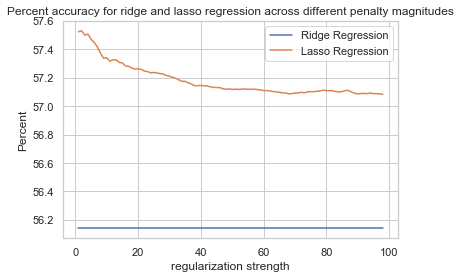

In [446]:
#Creating the lists to pull the values. X_test2 throws up a shape error on the lasso regression,
#So I'll leave it off for the test. The regression was trained on the same stuff, so hopefully that won't effect
#the results to much. 
lrr.fit(X, y)
lrl.fit(X, y)
estimates = np.append([0], lrr.score(X, y))
lestimates = np.append([0], lrl.score(X, y))


# Store scores.
score =[]
# Storing legend information.
labels = []

#Run the model for many alphas for ridge regression
for lambd in range(1, 99, 1):
    a = 1/lambd
    lrr = linear_model.LogisticRegression(penalty = 'l2', C=a, fit_intercept=False)
    lrr.fit(X, y)
    rscore = lrr.score(X, y)
    estimates = np.row_stack((
        estimates,
        np.append([lambd], rscore)))

#Running it again for lasso regression
for lambd in range(1, 99, 1):
    #Lasso regression goes on a scale from 0 to 1, so I'm going to adjust alphas accordingly. 
    a = 1/lambd
    lrl = linear_model.LogisticRegression(penalty = 'l1', C=a, fit_intercept=False)
    lrl.fit(X, y)
    lscore = lrl.score(X, y)
    lestimates = np.row_stack((
        lestimates,
        np.append([lambd], lscore)))
#Removing a set of outliers created by how we made the array. 
estimates = np.delete(estimates, 0, 0)
lestimates = np.delete(lestimates, 0, 0)
# Plot a line for each alpha for it's R2
plt.plot((estimates[:,0]), (estimates[:,1]*100), label='Ridge Regression')
plt.plot((lestimates[:,0]), (lestimates[:,1]*100), label='Lasso Regression')
#There is no regulization for the vannilla logistic regression, so I'll make it a flat line for comparison. 
plt.xlabel('regularization strength')
plt.title('Percent accuracy for ridge and lasso regression across different penalty magnitudes')
plt.ylabel('Percent')
plt.legend()
plt.show()

So lasso regression got too tough to early for the way that I coded in it's C value. I couldn't code it away from the value at which it deprived all of the variables. I'll examine the same issue in reverse, going up from C = 1 instead of down. 

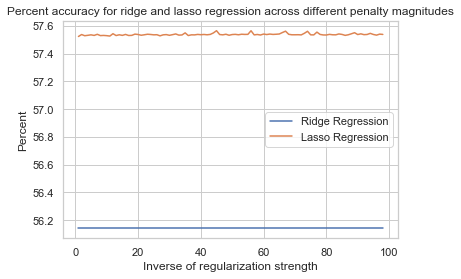

In [447]:
#Creating the lists to pull the values. X_test2 throws up a shape error on the lasso regression,
#So I'll leave it off for the test. The regression was trained on the same stuff, so hopefully that won't effect
#the results to much. 
lrr.fit(X, y)
lrl.fit(X, y)
estimates = np.append([0], lrr.score(X, y))
lestimates = np.append([0], lrl.score(X, y))


# Store scores.
score =[]
# Storing legend information.
labels = []

#Run the model for many alphas for ridge regression
for lambd in range(1, 99, 1):
    a = lambd
    lrr = linear_model.LogisticRegression(penalty = 'l2', C=a, fit_intercept=False)
    lrr.fit(X, y)
    rscore = lrr.score(X, y)
    estimates = np.row_stack((
        estimates,
        np.append([lambd], rscore)))

#Running it again for lasso regression
for lambd in range(1, 99, 1):
    #Lasso regression goes on a scale from 0 to 1, so I'm going to adjust alphas accordingly. 
    a = lambd
    lrl = linear_model.LogisticRegression(penalty = 'l1', C=a, fit_intercept=False)
    lrl.fit(X, y)
    lscore = lrl.score(X, y)
    lestimates = np.row_stack((
        lestimates,
        np.append([lambd], lscore)))
#Removing a set of outliers created by how we made the array. 
estimates = np.delete(estimates, 0, 0)
lestimates = np.delete(lestimates, 0, 0)
# Plot a line for each alpha for it's R2
plt.plot((estimates[:,0]), (estimates[:,1]*100), label='Ridge Regression')
plt.plot((lestimates[:,0]), (lestimates[:,1]*100), label='Lasso Regression')
#There is no regulization for the vannilla logistic regression, so I'll make it a flat line for comparison. 
plt.xlabel('Inverse of regularization strength')
plt.title('Percent accuracy for ridge and lasso regression across different penalty magnitudes')
plt.ylabel('Percent')
plt.legend()
plt.show()

That isn't terribly encouraging. We might have to see about different penalty strengths and compare them. 

Our random forest regressor did fine on price, but I did do lasso and ridge regressions to check if I could do better. They don't fit well in the rest of the notebook, so their detached from the actual declared training and test sets, and frankly aren't a core part of this project, but if you are curious about said preformance you can look below. 

In [92]:
#Lasso regression 
lass = linear_model.Lasso(alpha=.25)
lassfit = lass.fit(x_train, y_train)
print('R² for .25 alpha lasso regression:')
print(lass.score(x_test, y_test))
lassparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for lasso regression:')
print(lassparams)

# Small number of parameters.
ridge = linear_model.Ridge(alpha=.25)
ridgefit = ridge.fit(x_train, y_train)
print('R² for .25 alpha ridge regression:')
print(ridge.score(x_test, y_test))
ridgeparams = np.append(ridgefit.coef_, ridgefit.intercept_)
print('\nParameter estimates for lasso regression:')
print(ridgeparams)

C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R² for .25 alpha lasso regression:
0.6628298918609863

Parameter estimates for lasso regression:
[ 2.86445709e+02  2.06472262e+00 -5.93447530e-02 -5.70797350e+00
  2.82239884e+03  3.87365131e+00 -0.00000000e+00 -1.46297113e+02
 -1.68466932e+02  1.89202441e+03  1.90366529e+03 -2.11625443e+02
 -0.00000000e+00  0.00000000e+00  1.72050291e+03  1.94759472e+03
 -5.73209260e-13 -5.06114567e+03  0.00000000e+00 -3.27562674e+02
  1.78368626e+02  0.00000000e+00  6.67519399e+02 -7.19088480e+03
 -0.00000000e+00  1.05658296e+02  2.88769822e+03  1.25963108e+03
 -7.45833608e+03  1.03055034e+03 -1.36005426e+03  2.03954636e+03
 -6.30029065e+03 -0.00000000e+00  1.90167727e+03  2.34250895e+03
 -5.17382342e+03 -6.33445159e+03  6.28005762e+02 -3.82520501e+03
  2.58027683e+03  0.00000000e+00  2.68215458e+04 -7.02697644e+03
 -7.80743640e+03 -6.69280724e+03 -6.59960909e+03  3.36281013e+02
 -5.82138332e+03 -4.35737969e+03 -4.73406274e+03  7.81829147e+02
 -1.05994658e+03  1.73795021e+03  3.96200793e+01 -7.090155

C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase t

C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase t

C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase t

C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase t

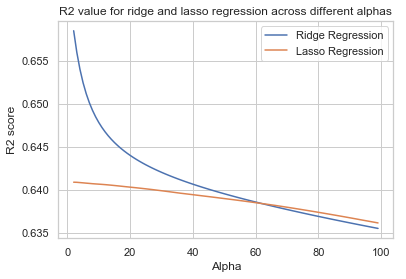

In [93]:
#Creating the lists to pull the values. X_test2 throws up a shape error on the lasso regression,
#So I'll leave it off for the test. The regression was trained on the same stuff, so hopefully that won't effect
#the results to much. 
estimates = np.append([0], ridge.score(x_test, y_test))
lestimates = np.append([0], lass.score(x_test, y_test))

# Store scores.
score =[]
# Storing legend information.
labels = []

#Run the model for many alphas for ridge regression
for lambd in range(2, 100, 1):
    ridge = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridge.fit(x_train, y_train)
    rscore = ridge.score(x_test, y_test)
    estimates = np.row_stack((
        estimates,
        np.append([lambd], rscore)))

#Running it again for lasso regression
for lambd in range(2, 100, 1):
    #Lasso regression goes on a scale from 0 to 1, so I'm going to adjust alphas accordingly. 
    a = lambd / 100
    lass = linear_model.Lasso(alpha=a, fit_intercept=False)
    lass.fit(x_train, y_train)
    lscore = lass.score(x_test, y_test)
    lestimates = np.row_stack((
        lestimates,
        np.append([lambd], lscore)))
#Removing a set of outliers created by how we made the array. 
estimates = np.delete(estimates, 0, 0)
lestimates = np.delete(lestimates, 0, 0)
# Plot a line for each alpha for it's R2
plt.plot(estimates[:,0], estimates[:,1], label='Ridge Regression')
plt.plot(lestimates[:,0], lestimates[:,1], label='Lasso Regression')
plt.xlabel('Alpha')
plt.title('R2 value for ridge and lasso regression across different alphas')
plt.ylabel('R2 score')
plt.legend()
plt.show()

In addition I made a few different visualizations, and examinations, just toying with the idea of putting them in the presentation. You can think of this as the cutting room floor, basically. If it's here, it's because I didn't use it. But I pulled quit a few of the visualizations out of here to use elsewhere in the capstone. So... not a terrible repository, overall. 

In [444]:
df.groupby(['fuelType']).mean()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,total_hours_uptime
fuelType,,,,,,
andere,3150.602273,1992.943182,94.409091,102386.363636,4.795455,291.450786
benzin,5079.639770,2001.597026,115.318465,121932.844685,5.957074,228.696928
cng,4914.942857,2006.063265,104.248980,128561.224490,6.542857,265.272898
diesel,8941.527747,2005.913486,139.847970,131022.419571,6.386030,231.646176
elektro,10118.709677,2009.500000,76.725806,53467.741935,5.741935,342.525614
hybrid,13789.725225,2009.788288,112.995495,80000.000000,6.734234,249.989057
lpg,4285.849198,2001.504726,150.161794,142300.505606,6.135854,239.357696


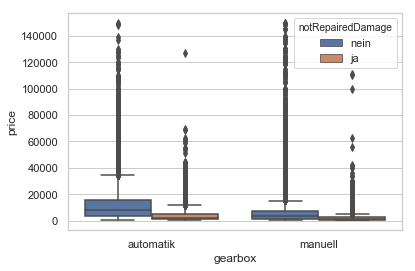

In [94]:
ax = sns.boxplot(x="gearbox", y="price", data=df,
                hue='notRepairedDamage')